<h1>Introduction to Pyspark</h1>

<h2>Creating temporary tables in Spark Sessions</h2>

<p>There is a .createTempView() which takes the name of the temporary table as the only argument.
It registers the DataFrame as a table in the catalog, but is temporary.
It can only be accessed from the specific SparkSession that was used.
</p>

<p>There is a .createOrReplaceTempView() method that safely creates a new temporary table if nothing was before or updates an existing
table.
It will avoid creating duplicate tables.
</p>

<h2>Interaction between Spark data structures</h2>

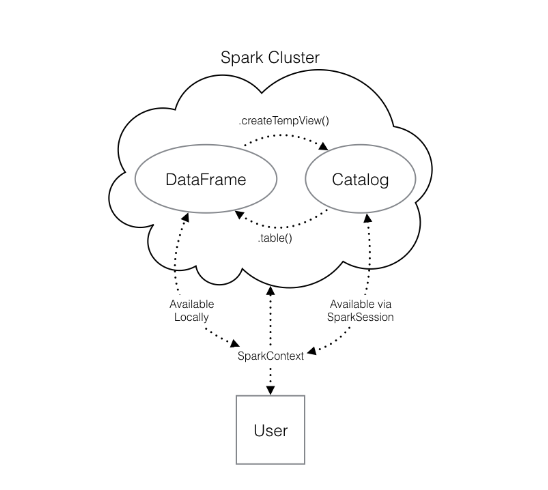


With this we can get our data in and out of Spark

In [26]:
import pandas as pd
import numpy as np
from  pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()


In [27]:
# Create pd_temp
pd_temp = pd.DataFrame(np.random.random(10))

# Create spark_temp from pd_temp
spark_temp = spark.createDataFrame(pd_temp)

# Examine the tables in the catalog
print(spark.catalog.listTables())

# Add spark_temp to the catalog
spark_temp.createOrReplaceTempView("temp")

# Examine the tables in the catalog again
print(spark.catalog.listTables())

[Table(name='temp', database=None, description=None, tableType='TEMPORARY', isTemporary=True)]
[Table(name='temp', database=None, description=None, tableType='TEMPORARY', isTemporary=True)]


<hr>
<h2>Load files directly to Spark</h2>

The SparkSession has a .read() attribute which has several methods for reading different data sources into Spark DataFrames.

<h2>Creating Columns</h2>

The .withColumn() method takes the next two arguments:
1. A string with the name of the new Column
2. The new column itself (object Class is Column)

<b>The name of the column could be an existing column, with that we are going to update the column that we specified.</b>

We can get a complete column by using df.colName

An Spark DataFrame is immutable. Because of this, the .withColumn() method returns a new Spark DataFrame that we have to reassign.


<h2>spark.table("name")</h2>
It will create a DataFrame containing the values of the table that we specify in the name attribute, the table must be in the .catalog

In [28]:
#Read csv with data
crimes = spark.read.csv("D:\Ingenieria\Plataformas de aprendizaje\Data Camp\Python\Data Types for Data Science in Python\Datasets\Crimes_-_2001_to_Present.csv",
header=True)

crimes.select("arrest").dtypes

[('arrest', 'string')]

In [29]:
#Add new column to existing pyspark DataFrame
from pyspark.sql.functions import col
crimes = crimes.withColumn("not arrested",
    crimes["arrest"]
)

crimes.select("not arrested").show()

+------------+
|not arrested|
+------------+
|       false|
|       false|
|       false|
|        true|
|       false|
|       false|
|       false|
|        true|
|       false|
|       false|
|       false|
|       false|
|       false|
|       false|
|       false|
|       false|
|       false|
|       false|
|        true|
|       false|
+------------+
only showing top 20 rows



<hr>
<h1>Examples with flights DataFrame</h1>

In [30]:
from pyspark.sql.functions import when, col
flights = spark.read.csv("./flights_small.csv",
header=True,
inferSchema =True, nanValue=0
)
#If the arr_delay was not null we could use:
# flights.withColumn("arr_delay", flights.arr_delay.cast("integer"))
flights = flights.withColumn("arr_delay",
when(flights.arr_delay == "NA", 0).otherwise(flights.arr_delay.cast("int")))

flights = flights.withColumn("air_time",
when(col("air_time") == "NA", 0).otherwise(col("air_time").cast("int")))

flights.dtypes

[('year', 'int'),
 ('month', 'int'),
 ('day', 'int'),
 ('dep_time', 'string'),
 ('dep_delay', 'string'),
 ('arr_time', 'string'),
 ('arr_delay', 'int'),
 ('carrier', 'string'),
 ('tailnum', 'string'),
 ('flight', 'int'),
 ('origin', 'string'),
 ('dest', 'string'),
 ('air_time', 'int'),
 ('distance', 'int'),
 ('hour', 'string'),
 ('minute', 'string')]

In [31]:
# Select the first set of columns
selected1 = flights.select("tailnum", "origin", "dest")

# Select the second set of columns
temp = flights.select(flights.origin, flights.dest, flights.carrier)

# Define first filter
filterA = flights.origin == "SEA"

# Define second filter
filterB = flights.dest == "PDX"

# Filter the data, first by filterA then by filterB
selected2 = temp.filter(filterA).filter(filterB)

In [32]:
# Define avg_speed
avg_speed = (flights.distance/(flights.air_time/60)).alias("avg_speed")

# Select the correct columns
speed1 = flights.select("origin", "dest", "tailnum", avg_speed)

# Create the same table using a SQL expression
speed2 = flights.selectExpr("origin", "dest", "tailnum", "distance/(air_time/60) as avg_speed")
flights.dtypes

[('year', 'int'),
 ('month', 'int'),
 ('day', 'int'),
 ('dep_time', 'string'),
 ('dep_delay', 'string'),
 ('arr_time', 'string'),
 ('arr_delay', 'int'),
 ('carrier', 'string'),
 ('tailnum', 'string'),
 ('flight', 'int'),
 ('origin', 'string'),
 ('dest', 'string'),
 ('air_time', 'int'),
 ('distance', 'int'),
 ('hour', 'string'),
 ('minute', 'string')]

<h1>Aggregating functions</h1>

df.groupBy().min("col").show()

If we don't specify a column for the groupBy, it will just create a GroupedData object which is necessary to use aggregation functions (min, max, count, etc)

In [33]:
# Find the shortest flight from PDX in terms of distance
flights.filter(flights.origin == 'PDX').groupBy().min("distance").show()

# Find the longest flight from SEA in terms of air time
flights.filter(flights.origin == 'SEA').groupBy().max("air_time").show()


+-------------+
|min(distance)|
+-------------+
|          106|
+-------------+

+-------------+
|max(air_time)|
+-------------+
|          409|
+-------------+



In [34]:
# Average duration of Delta flights
flights.filter(flights.carrier == "DL").filter(flights.origin == "SEA").groupBy().avg("air_time").show()

# Total hours in the air
flights.withColumn("duration_hrs", flights.air_time/60).groupBy().sum("duration_hrs").show()

# Group by tailnum
by_plane = flights.groupBy("tailnum")

# Number of flights each plane made
by_plane.count().show()

# Group by origin
by_origin = flights.groupBy("origin")

# Average duration of flights from PDX and SEA
by_origin.avg("air_time").show()

+------------------+
|     avg(air_time)|
+------------------+
|187.46103038309116|
+------------------+

+------------------+
| sum(duration_hrs)|
+------------------+
|25289.600000000126|
+------------------+

+-------+-----+
|tailnum|count|
+-------+-----+
| N442AS|   38|
| N102UW|    2|
| N36472|    4|
| N38451|    4|
| N73283|    4|
| N513UA|    2|
| N954WN|    5|
| N388DA|    3|
| N567AA|    1|
| N516UA|    2|
| N927DN|    1|
| N8322X|    1|
| N466SW|    1|
|  N6700|    1|
| N607AS|   45|
| N622SW|    4|
| N584AS|   31|
| N914WN|    4|
| N654AW|    2|
| N336NW|    1|
+-------+-----+
only showing top 20 rows

+------+------------------+
|origin|     avg(air_time)|
+------+------------------+
|   SEA|159.41471720461948|
|   PDX|135.76370918052987|
+------+------------------+



<h1>The pyspark.sql.functions submodule</h1>

The .agg() method lets us pass an aggregate column expression that uses any of the aggregate functions from the pyspark.sql.functions submodule.

It contains many useful functions for computing, all the aggregation functions take the name of a column in a GroupedData table.


In [35]:
# Import pyspark.sql.functions as F
import pyspark.sql.functions as F

# Group by month and dest
by_month_dest = flights.groupBy("month", "dest")

# Average departure delay by month and destination
by_month_dest.avg("air_time").show()


+-----+----+------------------+
|month|dest|     avg(air_time)|
+-----+----+------------------+
|    4| PHX|135.73333333333332|
|    1| RDM|            27.375|
|    5| ONT|119.77777777777777|
|    7| OMA|             162.0|
|    8| MDW|            218.15|
|    6| DEN|             121.6|
|    5| IAD| 266.6666666666667|
|   12| COS|             140.5|
|   11| ANC|192.91176470588235|
|    5| AUS|            215.25|
|    5| COS|             136.0|
|    2| PSP|             129.0|
|    4| ORD|200.35714285714286|
|   10| DFW|188.11764705882354|
|   10| DCA|             261.0|
|    8| JNU|           127.875|
|   11| KOA|             367.2|
|   10| OMA|             163.0|
|    6| ONT|             115.0|
|    3| MSP|             164.3|
+-----+----+------------------+
only showing top 20 rows



In [36]:
# Standard deviation of departure delay
by_month_dest.agg(F.stddev("air_time").alias("standard deviation")).show()

+-----+----+------------------+
|month|dest|standard deviation|
+-----+----+------------------+
|    4| PHX| 9.612609421328097|
|    1| RDM| 2.669269563007828|
|    5| ONT| 7.595685910070559|
|    7| OMA| 5.656854249492381|
|    8| MDW| 7.117620832538738|
|    6| DEN|24.823525281623628|
|    5| IAD|11.832159566199236|
|   12| COS|3.5355339059327378|
|   11| ANC|17.462284287830716|
|    5| AUS| 5.315072906367322|
|    5| COS|5.5677643628300215|
|    2| PSP| 17.67766952966369|
|    4| ORD| 33.47282948286342|
|   10| DFW|34.927426668591536|
|   10| DCA|  8.48528137423857|
|    8| JNU|10.855380496062109|
|   11| KOA| 16.90266251216062|
|   10| OMA| 5.291502622129181|
|    6| ONT| 9.913915184512842|
|    3| MSP| 6.936554582332948|
+-----+----+------------------+
only showing top 20 rows



<h1>Machine Learning Pipelines</h1>

To use machine learning tools we could use the pyspark.ml module which contains the Transformer and Estimator classes, they are the basic classes for ml.

<h2>Transformer</h2>
It has a .transform() method that takes a DataFrame and returns a new DataFrame which is the original with a new column appended.

<h2>Estimator</h2>
These classes implement the .fit() method which takes a DataFrame and return a model object.

Models that can be returned:

    - StringIndexerModel: For including categorical data saved as strings in our models.
    - RandomForestModel: It uses a random forest algorithm for classification or regression.


<hr>
<h1>Case Study</h1>

Building a model that predicts whether or not a flight will be delayed based on the flights data. It will also include information about the plane that flew the route.

In [37]:
planes = spark.read.csv("./planes.csv",
header=True,
inferSchema =True, nanValue=0
)
planes = planes.withColumnRenamed("year", "plane_year")

# Join the DataFrames
flights = flights.join(planes, on="tailnum", how="leftouter")
flights.dtypes

[('tailnum', 'string'),
 ('year', 'int'),
 ('month', 'int'),
 ('day', 'int'),
 ('dep_time', 'string'),
 ('dep_delay', 'string'),
 ('arr_time', 'string'),
 ('arr_delay', 'int'),
 ('carrier', 'string'),
 ('flight', 'int'),
 ('origin', 'string'),
 ('dest', 'string'),
 ('air_time', 'int'),
 ('distance', 'int'),
 ('hour', 'string'),
 ('minute', 'string'),
 ('plane_year', 'string'),
 ('type', 'string'),
 ('manufacturer', 'string'),
 ('model', 'string'),
 ('engines', 'int'),
 ('seats', 'int'),
 ('speed', 'string'),
 ('engine', 'string')]

<h1>Data types</h1>

Spark fro machine learning only handles numeric data. This means that all the columns of the DataFrame must be either integers or decimals (doubles).

In order to convert a string column to int or double we could use the .cast("valueType") method combined with .withColumn() method.
    
    .cast() works on columns while .withColumn() works with dataFrames



In [38]:
#If the arr_delay was not null we could use:
# flights.withColumn("arr_delay", flights.arr_delay.cast("integer"))

flights = flights.withColumn("plane_age", flights.year - flights.plane_year)
flights.select("year", "plane_year", "plane_age").show()

+----+----------+---------+
|year|plane_year|plane_age|
+----+----------+---------+
|2014|      2011|      3.0|
|2014|      2006|      8.0|
|2014|      2011|      3.0|
|2014|      1992|     22.0|
|2014|      1999|     15.0|
|2014|      1997|     17.0|
|2014|      2002|     12.0|
|2014|      2013|      1.0|
|2014|      2001|     13.0|
|2014|      2006|      8.0|
|2014|      2004|     10.0|
|2014|      2001|     13.0|
|2014|      2013|      1.0|
|2014|      1992|     22.0|
|2014|      1999|     15.0|
|2014|      2000|     14.0|
|2014|      2001|     13.0|
|2014|      2014|      0.0|
|2014|      2008|      6.0|
|2014|      2001|     13.0|
+----+----------+---------+
only showing top 20 rows



<h1>Making booleans</h1>

In [39]:
# Create is_late
flights = flights.withColumn("is_late", flights.arr_delay > 0)

# Convert to an integer
flights = flights.withColumn("label", flights.is_late.cast("int"))

# Remove missing values
flights = flights.filter("arr_delay is not NULL and dep_delay is not NULL and air_time is not NULL and plane_year is not NULL")
flights.show()

+-------+----+-----+---+--------+---------+--------+---------+-------+------+------+----+--------+--------+----+------+----------+--------------------+--------------+-----------+-------+-----+-----+---------+---------+-------+-----+
|tailnum|year|month|day|dep_time|dep_delay|arr_time|arr_delay|carrier|flight|origin|dest|air_time|distance|hour|minute|plane_year|                type|  manufacturer|      model|engines|seats|speed|   engine|plane_age|is_late|label|
+-------+----+-----+---+--------+---------+--------+---------+-------+------+------+----+--------+--------+----+------+----------+--------------------+--------------+-----------+-------+-----+-----+---------+---------+-------+-----+
| N846VA|2014|   12|  8|     658|       -7|     935|       -5|     VX|  1780|   SEA| LAX|     132|     954|   6|    58|      2011|Fixed wing multi ...|        AIRBUS|   A320-214|      2|  182|   NA|Turbo-fan|      3.0|  false|    0|
| N559AS|2014|    1| 22|    1040|        5|    1505|        5|     A

<h1>Strings and factors</h1>

Sparks require numeric data for modeling. We have to convert strings into a numeric data type.

In order to convert strings to numeric types we can use the pyspark.ml.features submodule. We can create 'one-hot vectors' which are a way of representing a categorical feature where every observation has a vector in which all elements are zero except for at most one element which has a value of one.

Each element in the vector corresponds to a level of the feature so it's possible to tell what the right level is by seeing which element of the vector is equal to one.

Steps:

1. Create a StringIndexer: Members of this class are Estimator's that take a DataFrame with a column of strings and map each unique string to a number.
2. The Estimator returns a Transformer that takes a Df, attaches the mapping to it as metadata and returns a new Df with a numeric column corresponding to the string column.
3. Encode the numeric column as a one-hot vector using a OneHotEncoder. It works exactly as the StringIndexer by creating an Estimator and then a Transformer. The end result is a column that encodes your categorical feature as a vector that's suitable for machine learning routines.

In [40]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
#inputCol is the name of the column we want to index or encode
#outputCol is the name of the new column that the Transformer should create

# Create a StringIndexer
carr_indexer = StringIndexer(inputCol="carrier", outputCol="carrier_index")

# Create a OneHotEncoder
carr_encoder = OneHotEncoder(inputCol="carrier_index", outputCol="carrier_fact")

# Create a StringIndexer
dest_indexer = StringIndexer(inputCol="dest", outputCol="dest_index")

# Create a OneHotEncoder
dest_encoder = OneHotEncoder(inputCol="dest_index", outputCol="dest_fact")

<h1>Assemble a vector</h1>

After creating the columns we have to combine this features into a single column. It has to be done before modeling can take place because every park modeling routine expects the data in this form.

We can do so by storing each value from a column as an entry in a vector. Every observation is a vector that contains all the information about it and a label that tells the modeler what value that observation corresponds to.

pyspark.ml.feature contains a class called VectorAssembler. It's a Transformer that takes all of the columns we specify and combines them into a new vector column.


In [41]:
from pyspark.ml.feature import VectorAssembler
# Make a VectorAssembler
vec_assembler = VectorAssembler(inputCols=["month", "air_time", "carrier_fact", "dest_fact", "plane_age"], outputCol="features")

<h1>Create a machine Learning Pipeline</h1>

Is a class in the pyspark.ml module that combines all the Estimators and Transformers that we have already created.


Call the Pipeline() constructor with the keyword argument stages to create a Pipeline called flights_pipe.

stages should be a list holding all the stages you want your data to go through in the pipeline. Here this is just:

The last step must be the VectorAssembler

In [42]:
from pyspark.ml import Pipeline

# Make the pipeline
flights_pipe = Pipeline(stages=[dest_indexer, dest_encoder, carr_indexer, carr_encoder, vec_assembler])

<h1>Test vs. Train data</h1>

We should not touch the test data until we have a good model. Instead, we should use training data to get an idea of the performance.

Once we've got our model, we can see how well it predicts the new data in the test set which will give us a realistic idea of the model's performance when trying to classify new data.

We must split the data after all the transformations, this is because some operations don't always produce the same index even when given the same list of strings. 

In [43]:
# Fit and transform the data
piped_data = flights_pipe.fit(flights).transform(flights)

#Split the data
#60% to training
# 40% to testing
# Split the data into training and test sets
training, test = piped_data.randomSplit([.6, .4])

<h1>Logistic regression</h1>

Is very similar to a linear regression, but instead of predicting a numeric variable, it predicts the probability of an event.

To use this as a classification algorithm, we have to assign a cutoff point to the probabilities. If the probability is above the cutoff we mark it as 'yes' (flight being late in this case), otherwise we set it as 'no'.

<h2>hyperparameters</h2>

Is a value in the model that's not estimated from the data, is supplied by the user to maximize performance.

In [44]:
# Import LogisticRegression
from pyspark.ml.classification import LogisticRegression

# Create a LogisticRegression Estimator
lr = LogisticRegression()

<h1>Cross validation</h1>

We are going to turn the logistic regression model using a procedure called k-fold cross validation. It's a method of estimating the model's performance on unseen data (test data).

It splits the training data into a few different partitions. The number is up to us (default = 3). Once the data is split up, one of the partitions is set aside, and the model is fit to the others. The error is measured against the held out partition. This is done with the three partitions, then the error in each partition is averaged. Is a goode estimate of the actual error on the held out data.

We are going to use cross validation to choose the hyperparameters by creating a gri of the possible pairs of values for the two hyperparameters, elasticNetParam and regParam, and using the cross validation error to define the best model.

<center><b >The cross validation error is an estimate of the model's error on the test set.</b></center>

The first thing you need when doing cross validation for model selection is a way to compare different models, we can use pyspark.ml.evaluation submodel for that.

We could use a BinaryClassificationEvaluator from  pyspark.ml.evaluation module for the model.

<h2>ROC</h2>

Is a metric that combines the two kinds of errors a binary classifier which are:

1. False positives.
2. False negatives.

In [45]:
# Import the evaluation submodule
import pyspark.ml.evaluation as evals

# Create a BinaryClassificationEvaluator
evaluator = evals.BinaryClassificationEvaluator(metricName="areaUnderROC")

<h1>Making a grid</h1>

We can use the submodule pyspark.ml.tuning which includes the ParamGridBuilder class that e have to create a grid of values to search over when looking for the optimal hyperparameters.

We are going to use the .addGrid() and .build() methods to create a grid that you can use for cross validation.

1. .addGrid() takes a model parameter (is an attribute of the model Estimator, lr) and a list of values that we want to try.
2. .build() takes no arguments it just returns the grid that we are going to use.

Call the .addGrid() method on grid with lr.regParam as the first argument and np.arange(0, .1, .01) as the second argument. This second call is a function from the numpy module (imported as np) that creates a list of numbers from 0 to .1, incrementing by .01. Overwrite grid with the result.

<h1>Make the validator</h1>

The submodule pyspark.ml.tuning also has a class called CrossValidator for performing cross validation. This Estimator takes the modeler you want to fit, the grid of hyperparameters you created, and the evaluator you want to use to compare your models.

In [46]:
# Import the tuning submodule
import pyspark.ml.tuning as tune
import numpy as np

# Create the parameter grid
grid = tune.ParamGridBuilder()

# Add the hyperparameter
grid = grid.addGrid(lr.regParam, np.arange(0, .1, .01))
grid = grid.addGrid(lr.elasticNetParam, [0, 1])

# Build the grid
grid = grid.build()

# Create the CrossValidator
cv = tune.CrossValidator(estimator=lr,
               estimatorParamMaps=grid,
               evaluator=evaluator
               )

<h1>Fit the model</h1>

Unfortunately, cross validation is a very computationally intensive procedure. Fitting all the models would take too long.

emember, the training data is called training and you're using lr to fit a logistic regression model. Cross validation selected the parameter values regParam=0 and elasticNetParam=0 as being the best. These are the default values, so you don't need to do anything else with lr before fitting the model.

<h1>Test the model</h1>

Using the test data.

In [ ]:
# Fit cross validation models
models = lr.fit(training)

# Extract the best model
best_lr = models.bestModel

# Use the model to predict the test set
test_results = best_lr.transform(test)

# Evaluate the predictions
print(evaluator.evaluate(test_results))

#UAC for the model: 0.7123313100891033